Topic: Project 3      
Subject: Analyzing Classification Algorithms  
Date: 10/25/2017   
Name: Zach Heick  

**Order of Events**  
  1. [Storing Raw League of Legends Data](https://github.com/ZachHeick/Project_McNulty/blob/master/Project_Notebooks/Project_McNulty_SQL_Alchemy.ipynb)  
  2. [Cleaning League of Legends Data](https://github.com/ZachHeick/Project_McNulty/blob/master/Project_Notebooks/Project_McNulty_Cleaning.ipynb)  
  3. [Creating Dataframes for EDA](https://github.com/ZachHeick/Project_McNulty/blob/master/Project_Notebooks/Project_McNulty_Creating_EDA_Dataframes.ipynb)  
  4. [Visualizing League of Legends Data](https://github.com/ZachHeick/Project_McNulty/blob/master/Project_Notebooks/Project_McNulty_EDA_Visuals.ipynb)  
  5. [Analyzing Classification Algorithms](https://github.com/ZachHeick/Project_McNulty/blob/master/Project_Notebooks/Project_McNulty_Modeling.ipynb)

**Summary**: With the data cleaned and analyzed, I explored multiple classification algorithms and compared results. The goal was to pick single or multiple algorithms for my final model. The metric I used was accuracy.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
model_df = pd.read_pickle('model_df.pickle')
champ_df = pd.read_pickle('champ_info.pickle')

# Features

For features, I'm interested in using the picks and bans for each team, as well as which team secured the objectives first.

In [3]:
team_cols = ['blue_champ1id', 'blue_champ2id', 'blue_champ3id', 'blue_champ4id', 'blue_champ5id',
                  'red_champ1id', 'red_champ2id', 'red_champ3id', 'red_champ4id', 'red_champ5id']

objective_cols = ['firstBlood', 'firstTower', 'firstDragon', 'firstRiftHerald']


ban_cols = ['blue_ban1', 'blue_ban2', 'blue_ban3', 'blue_ban4', 'blue_ban5', 
            'red_ban1', 'red_ban2', 'red_ban3', 'red_ban4', 'red_ban5'
]

Split the data into train and test sets. Stratifying keeps the distribution of `y_train` and `y_test` the same.

In [4]:
X = model_df[objective_cols + team_cols + ban_cols]
y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32595, stratify=y)

Because all of the features are categorical, they need to be dummied.

In [5]:
for col in objective_cols + team_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [6]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Functions
Some helper functions for tuning hyperparameters and plotting.

In [7]:
def tune_hyperparameter(param_grid, algorithm, score, X, y):
    """
    Uses GridSearchCV to find the best hyperparameters for an
    algorithm. Prints the best score, parameter, and estimator.
    
    :param param_grid: list or dictionary of hyperparameters
    :param algorithm: classification algorithm to tune
    :param score: the metric type
    :param X: features set
    :param y: target set
    :returns: Grid object
    """
    grid = GridSearchCV(algorithm, param_grid, cv=10, scoring=score)
    grid.fit(X,y)
    print('Best Score: ' + str(grid.best_score_))
    print('Best Parameter: ' + str(grid.best_params_))
    print('Best Estimator: ' + str(grid.best_estimator_))
    return grid

In [24]:
def graph_error(grid, param_list):
    """
    Plots the metric error graph.
    
    :param grid: grid object of multiple models with different parameters
    :param_list: list of hyperparameters
    """
    mean_scores = []
    for item in grid.grid_scores_:
        mean_scores.append(np.mean(item[2]))
        
    plt.figure(figsize=(10,7))
    plt.ylabel('Accuracy', size=16)
    
    x = [i for i in range(0, len(param_list))]
    y = mean_scores
    
    if len(param_list) >= 20:
        plt.plot(x, y, 'b-o', label='Actual')
        plt.xticks(x[::2], param_list[::2], size=14)
        
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)
        
        x_fit = np.linspace(x[0], x[-1], 50)
        y_fit = f(x_fit)
        
        plt.plot(x_fit, y_fit, '--m', label='Estimate')
        plt.legend(loc='best', prop={'size':14})

    else:
        plt.plot(x, y, 'b-o')
        plt.xticks(x, param_list, size=14)
        
    plt.yticks(size=14)

In [9]:
def graph_learning_curve(algorithm, X, y):
    """
    Plots the learning curve of an algorithm.
    
    :param algorithm: the algorithm to plot
    :param X: features set
    :param y: target set
    """
    m,train_err,ts_err = learning_curve(algorithm,
                                    X,
                                    y, 
                                    train_sizes=np.linspace(0.1, 1.0, 20))

    train_cv_err = np.mean(train_err,axis=1)
    test_cv_err = np.mean(ts_err,axis=1)

    plt.figure(figsize=(10,7))
    plt.ylabel('Accuracy', size=16)
    plt.xlabel('Data Samples', size=16)
    plt.yticks(size=14)
    plt.xticks(size=14)
    tr, = plt.plot(m,train_cv_err, 'm')
    ts, = plt.plot(m,test_cv_err, '--r')
    plt.legend((tr,ts),('train','test'),loc='best', prop={'size':12});

# Algorithms 
Algorithms and hyperparameters:
  * Support Vector Machines: Budget
  * Decision Tree: Depth and criterion
  * Random Forest: Depth and number of trees
  * Logistic Regression: Regularization Strength
  * Bernoulli Naive Bayes: None

Process for each algorithm (excluding Bernoulli Naive Bayes):  
  1. Select hyperparameters for tuning
  2. Use `GridSearchCV` to find parameter that gives the best accuracy score
  3. Graph the accuracy scores with respect to parameter value
  4. Record final scores from the test set and plot learning curve

### SVM

In [12]:
c_list = [10 ** i for i in range(-10,1)]
c_list

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [13]:
svm_param_grid = dict(C = c_list)
svm_grid = tune_hyperparameter(svm_param_grid, LinearSVC(), 'accuracy', X_train, y_train)

Best Score: 0.720619261284
Best Parameter: {'C': 0.0001}
Best Estimator: LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


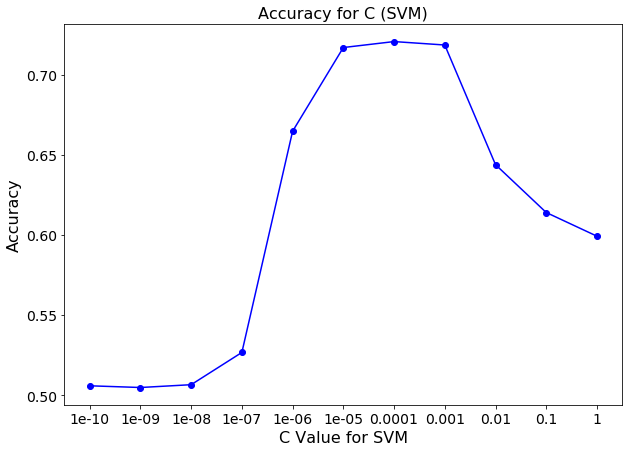

In [14]:
graph_error(svm_grid, c_list)
plt.xlabel('C Value for SVM', size=16)
plt.title('Accuracy for C (SVM)', size=16);

In [15]:
svm = CalibratedClassifierCV(LinearSVC(C=0.0001)).fit(X_train, y_train)
svm_test_pred = svm.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, svm_test_pred))
print('Precision: ', precision_score(y_test, svm_test_pred))
print('Recall: ', recall_score(y_test, svm_test_pred))
print('F1: ', f1_score(y_test, svm_test_pred))

Accuracy:  0.717415418747
Precision:  0.71661062542
Recall:  0.730163080718
F1:  0.723323377681


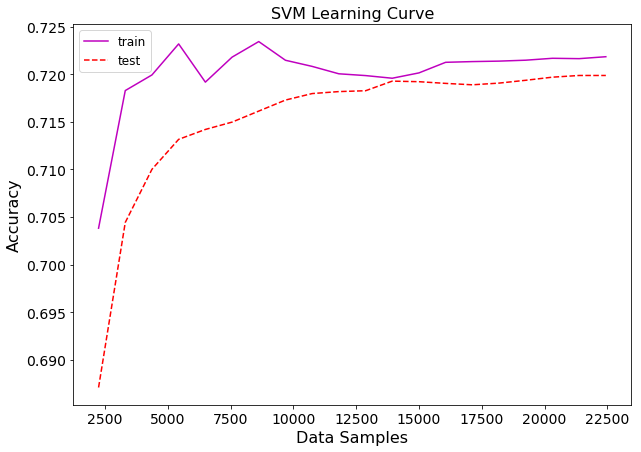

In [16]:
graph_learning_curve(svm, X_train, y_train)
plt.title('SVM Learning Curve', size=16);

### Decision Tree

In [17]:
depths = [i for i in range(1,11)]
dt_param_grid = dict(max_depth = depths, criterion = ['gini', 'entropy'])
dt_grid = tune_hyperparameter(dt_param_grid, DecisionTreeClassifier(), 'accuracy', X_train, y_train)

Best Score: 0.716726591983
Best Parameter: {'criterion': 'gini', 'max_depth': 5}
Best Estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


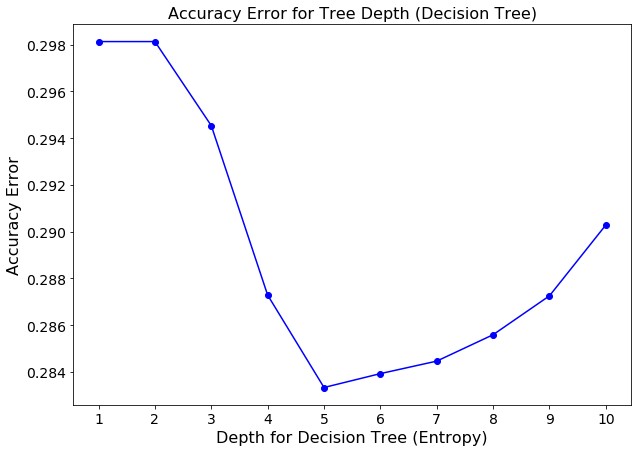

In [21]:
mean_scores = []
for item in dt_grid.grid_scores_[10:]:
    mean_scores.append(np.mean(item[2]))

plt.figure(figsize=(10,7))
plt.xlabel('Depth for Decision Tree (Entropy)', size=16)
plt.ylabel('Accuracy Error', size=16)

plt.plot([i for i in range(0, len(depths))], [1-score for score in mean_scores], 'b-o')
plt.xticks([i for i in range(0, len(depths))], depths, size=14)
plt.yticks(size=14)
plt.title('Accuracy Error for Tree Depth (Decision Tree)', size=16);

In [19]:
dt = DecisionTreeClassifier(max_depth=5, criterion='entropy').fit(X_train, y_train)
dt_test_pred = dt.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, dt_test_pred))
print('Precision: ', precision_score(y_test, dt_test_pred))
print('Recall: ', recall_score(y_test, dt_test_pred))
print('F1: ', f1_score(y_test, dt_test_pred))

Accuracy:  0.714711591791
Precision:  0.706141487432
Recall:  0.746882280389
F1:  0.725940725941


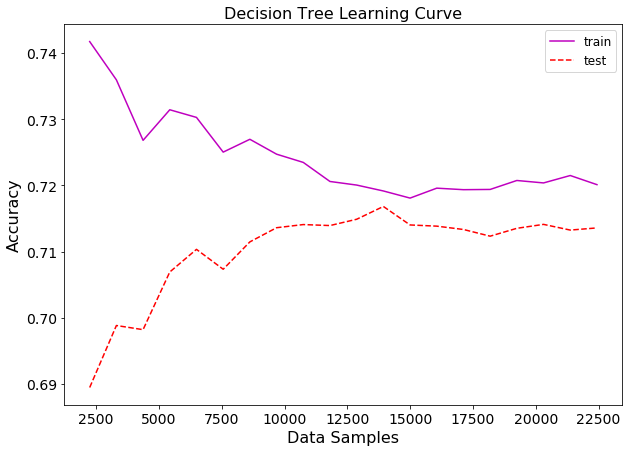

In [20]:
graph_learning_curve(dt, X_train, y_train)
plt.title('Decision Tree Learning Curve', size=16);

### Random Forest

In [25]:
depths = [i for i in range(1,21)]
rf_param_grid = dict(max_depth = depths)
rf_depth_grid = tune_hyperparameter(rf_param_grid, 
                                    RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=123), 
                                    None, X_train, y_train)

Best Score: 0.714260244258
Best Parameter: {'max_depth': 20}
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)


To prevent overfitting, I won't choose the recommended parameter value for Random Forest. I'll instead look at the estimate curve and choose a value where the curve began to plateau.

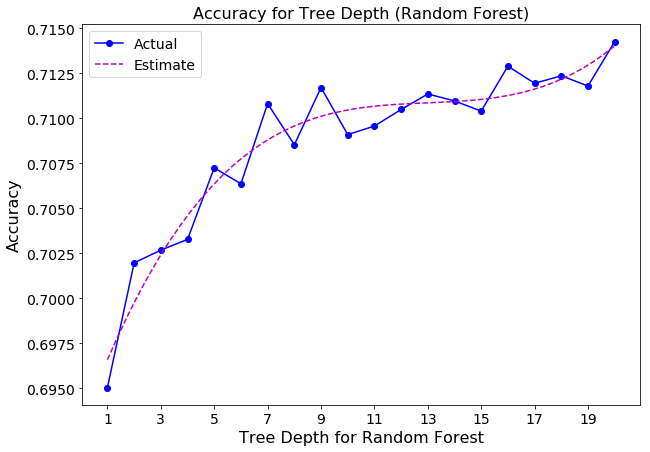

In [27]:
graph_error(rf_depth_grid, depths)
plt.xlabel('Tree Depth for Random Forest', size=16)
plt.title('Accuracy for Tree Depth (Random Forest)', size=16);

In [28]:
num_trees = [i for i in range(1,21)]
rf_param_grid = dict(n_estimators = num_trees)
rf_trees_grid = tune_hyperparameter(rf_param_grid, RandomForestClassifier(n_jobs=-1, oob_score=True, max_depth=13), 
                                    None, X_train, y_train)

Best Score: 0.715954001129
Best Parameter: {'n_estimators': 17}
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


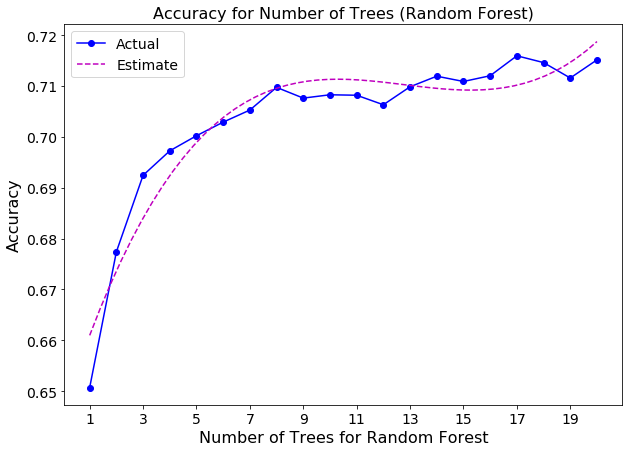

In [29]:
graph_error(rf_trees_grid, num_trees)
plt.xlabel('Number of Trees for Random Forest', size=16)
plt.title('Accuracy for Number of Trees (Random Forest)', size=16);

In [30]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators=9, max_depth=13).fit(X_train, y_train)
rf_test_pred = rf.predict(X_test)
print(rf.oob_score_)

0.6938460167


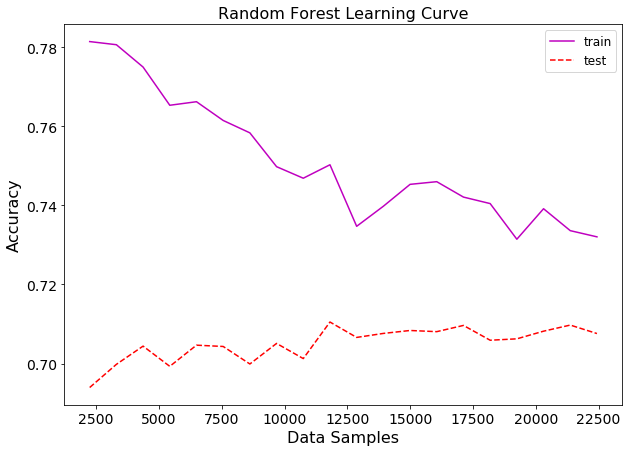

In [31]:
graph_learning_curve(rf, X_train, y_train)
plt.title('Random Forest Learning Curve', size=16);

### Logistic Regression

In [32]:
lr_param_grid = dict(C = c_list)
lr_grid = tune_hyperparameter(lr_param_grid, LogisticRegression(), 'accuracy', X_train, y_train)

Best Score: 0.726532552818
Best Parameter: {'C': 0.01}
Best Estimator: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


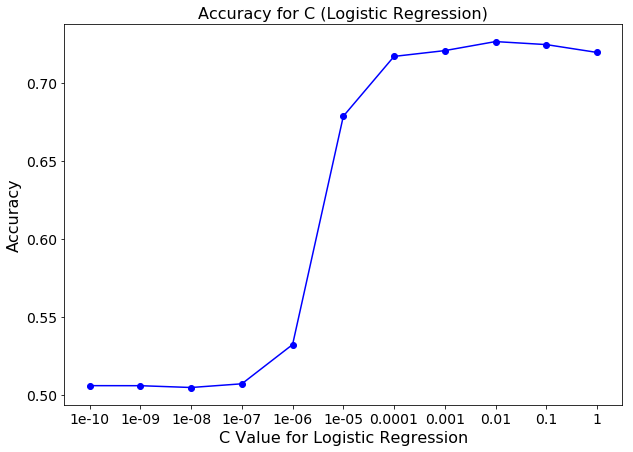

In [33]:
graph_error(lr_grid, c_list)
plt.xlabel('C Value for Logistic Regression', size=16)
plt.title('Accuracy for C (Logistic Regression)', size=16);

In [34]:
lr = LogisticRegression(C=0.01).fit(X_train, y_train)
lr_test_pred = lr.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, lr_test_pred))
print('Precision: ', precision_score(y_test, lr_test_pred))
print('Recall: ', recall_score(y_test, lr_test_pred))
print('F1: ', f1_score(y_test, lr_test_pred))

Accuracy:  0.725665557404
Precision:  0.724341751746
Recall:  0.738933808414
F1:  0.731565022726


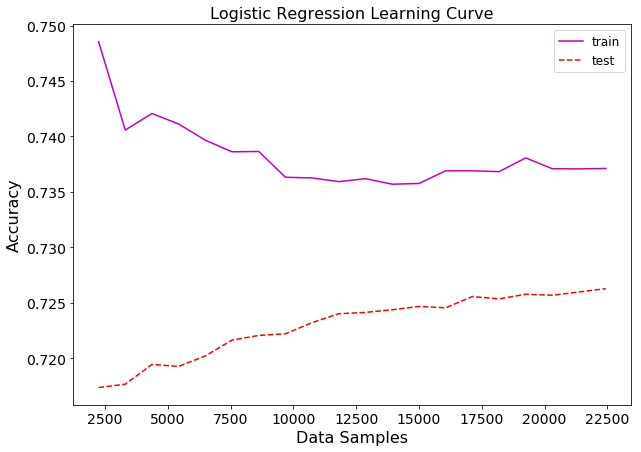

In [35]:
graph_learning_curve(lr, X_train, y_train)
plt.title('Logistic Regression Learning Curve', size=16);

### Bernoulli Naive Bayes

In [40]:
cross_val_score(BernoulliNB(), X_train, y_train, cv=10)

array([ 0.72608437,  0.72697564,  0.72489602,  0.72251931,  0.73024361,
        0.71857355,  0.70728083,  0.7179792 ,  0.72859691,  0.71730083])

In [37]:
b_NB = BernoulliNB().fit(X_train, y_train)
b_NB_test_pred = b_NB.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, b_NB_test_pred))
print('Precision: ', precision_score(y_test, b_NB_test_pred))
print('Recall: ', recall_score(y_test, b_NB_test_pred))
print('F1: ', f1_score(y_test, b_NB_test_pred))

Accuracy:  0.721436494731
Precision:  0.722305084746
Recall:  0.730026038098
F1:  0.726145038168


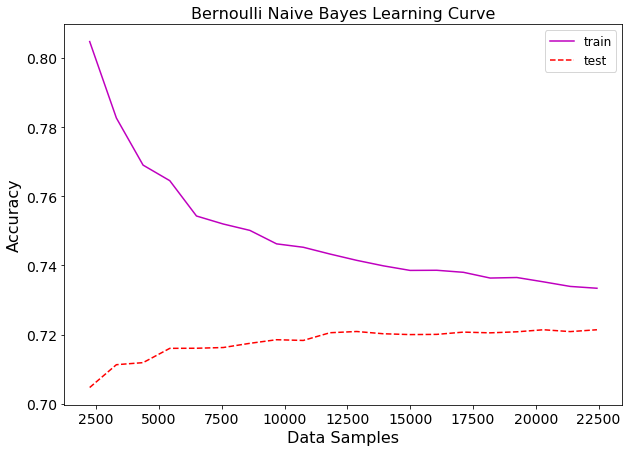

In [38]:
graph_learning_curve(b_NB, X_train, y_train)
plt.title('Bernoulli Naive Bayes Learning Curve', size=16);

# Algorithm Analysis

### ROC Curves

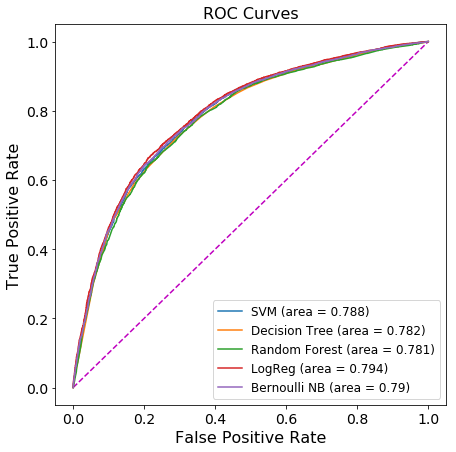

In [41]:
svm_yprobpred = svm.predict_proba(X_test)
dt_yprobpred = dt.predict_proba(X_test)
rf_yprobpred = rf.predict_proba(X_test)
lr_yprobpred = lr.predict_proba(X_test)
b_NB_yprobpred = b_NB.predict_proba(X_test)

svm_fpr, svm_tpr,_ = roc_curve(y_test, svm_yprobpred[:,1], pos_label=1)
svm_roc_auc = 1-auc(svm_fpr, svm_tpr)

dt_fpr, dt_tpr,_ = roc_curve(y_test, dt_yprobpred[:,1], pos_label=1)
dt_roc_auc = 1-auc(dt_fpr, dt_tpr)

rf_fpr, rf_tpr,_ = roc_curve(y_test, rf_yprobpred[:,1], pos_label=1)
rf_roc_auc = 1-auc(rf_fpr, rf_tpr)

lr_fpr, lr_tpr,_ = roc_curve(y_test, lr_yprobpred[:,1], pos_label=1)
lr_roc_auc = 1-auc(lr_fpr, lr_tpr)

b_NB_fpr, b_NB_tpr,_ = roc_curve(y_test, b_NB_yprobpred[:,1], pos_label=1)
b_NB_roc_auc = 1-auc(b_NB_fpr, b_NB_tpr)

plt.figure(figsize=(7,7))

plt.plot([0,1],[0,1],'--m')
plt.plot(svm_tpr, svm_fpr, label='SVM (area = %0.3f)' % svm_roc_auc)
plt.plot(dt_tpr, dt_fpr, label='Decision Tree (area = %0.3f)' % dt_roc_auc)
plt.plot(rf_tpr, rf_fpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot(lr_tpr, lr_fpr, label='LogReg (area = %0.3f)' % lr_roc_auc)
plt.plot(b_NB_tpr, b_NB_fpr, label='Bernoulli NB (area = %0.2f)' % b_NB_roc_auc)
plt.title('ROC Curves', size=16)
plt.legend(loc="lower right", prop={'size':12})
plt.xlabel('False Positive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.xticks(size=14)
plt.yticks(size=14);

### Boxplot

In [42]:
svm_scores = [score[2] for score in svm_grid.grid_scores_ if score[0]['C'] == 0.001]
dt_scores = [score[2] for score in dt_grid.grid_scores_ if score[0]['max_depth'] == 5 and score[0]['criterion'] == 'entropy']
rf_scores = [score[2] for score in rf_trees_grid.grid_scores_ if score[0]['n_estimators'] == 9]
lr_scores = [score[2] for score in lr_grid.grid_scores_ if score[0]['C'] == 0.01]
b_NB_scores = cross_val_score(BernoulliNB(), X_train, y_train, cv=10)

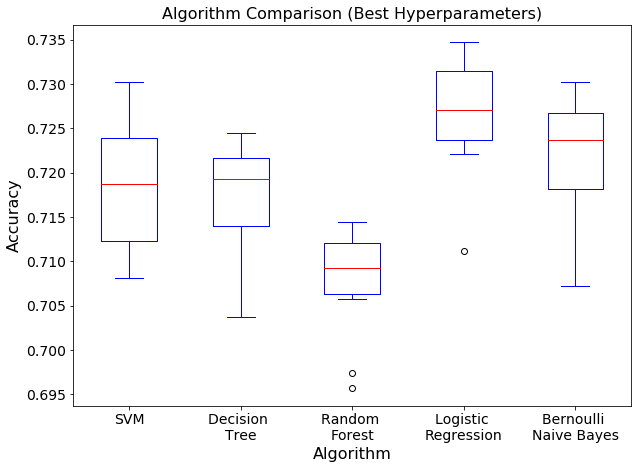

In [43]:
plt.figure(figsize=(10,7))
plt.boxplot([svm_scores, dt_scores, rf_scores, lr_scores, b_NB_scores], 
            boxprops=dict(color='b'),
            capprops=dict(color='b'),
            whiskerprops=dict(color='b'),
            medianprops=dict(color='r'))
plt.xticks([1,2,3,4,5], ['SVM', 'Decision \nTree', 'Random \nForest', 'Logistic \nRegression', 'Bernoulli \nNaive Bayes'], size=14)
plt.yticks(size=14)
plt.title('Algorithm Comparison (Best Hyperparameters)', size=16)
plt.xlabel('Algorithm', size=16)
plt.ylabel('Accuracy', size=16);

### Comparing Incorrect Predictions
Because of how similar the algorithms performed when looking at the ROC curves and boxplot, I was curious to see which games each algorithm was predicting incorrectly.

In [44]:
def get_incorrect_predictions(model_ypredict, y_test):            
    wrong = []
    for i, pair in enumerate(zip(model_ypredict, y_test)):
        if pair[0] != pair[1]:
            wrong.append(i)
            
    return wrong

In [45]:
lr_wrong = get_incorrect_predictions(lr_test_pred, y_test)
b_NB_wrong = get_incorrect_predictions(b_NB_test_pred, y_test)
rf_wrong = get_incorrect_predictions(rf_test_pred, y_test)
svm_wrong = get_incorrect_predictions(svm_test_pred, y_test)
dt_wrong = get_incorrect_predictions(dt_test_pred, y_test)

wrong_d = {
    'SVM':svm_wrong,
    'Decision Tree':dt_wrong,
    'Random Forest':rf_wrong,
    'Logistic Regression':lr_wrong,
    'Bernoulli NB':b_NB_wrong
}

In [46]:
def compare_errors(wrong_d, start=0, end=10):
    wrong_d_sample = {}
    for key, value in wrong_d.items():
        wrong_d_sample[key] = value[start:end]
    return wrong_d_sample

In [47]:
df = pd.DataFrame.from_dict(compare_errors(wrong_d))

Each value in the dataframe represents the game index that was incorrectly predicted. For every algorithm, it looks like nearly all of the same games are being predicted wrong. This eliminates the possibility to ensemble different algorithms.

In [48]:
d = dict(selector="th",
    props=[('text-align', 'center')])

df = df.style.set_properties(**{'width':'10em', 'text-align':'center'})\
        .set_table_styles([d])
df

,Bernoulli NB,Decision Tree,Logistic Regression,Random Forest,SVM
0,10,10,1,10,10
1,14,14,10,14,14
2,15,15,14,15,15
3,16,19,15,19,16
4,19,21,19,21,19
5,21,22,21,22,21
6,22,23,22,23,22
7,23,24,23,24,23
8,24,27,24,27,24
9,27,28,27,28,27


# Conclusion  

All five algorithms behaved very similarly in this project. When it came down to picking an algorithm, I focused on three categories: accuracy of the algorithm, interpretability, and computation time. I chose **Support Vector Machine**, which performed best for these three categories in this project with an accuracy score of 71.7%.